In [17]:
import re
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [18]:
runs = [15, 16, 17]
methods = ['random', 'state', 'trace']
bug_types = ['Large LogIndex: %d']
slice_ = 20000

coverages = {
    "random": [],
    "state": [],
    "trace": [],
}
coverages_plot = {
    "Random": [],
    "ModelFuzz": [],
    "Trace": [], 
}
rev_map = {
    "random": "Random",
    "state": "ModelFuzz",
    "trace": "Trace",
}

for run in runs:
    for method in coverages.keys():
        basedir = f'experiments/raft_3_3/{method}/output{run}/'
        with open(os.path.join(basedir, f'saved/{method}_stats.pkl'), 'rb') as f:
            stats = pkl.load(f)
        coverages[method].append(stats['coverage'][:slice_])
        # print(f'Length: {len(stats["coverage"])}')
        # print(f'Coverage: {stats["coverage"][:slice_][-1]}')
        # print(f'Len bug_iters: {len(stats["bug_iterations"])}')
        # print(f'Bug_iters:')
        # print(stats["bug_iterations"])
        # print('-------------------------')

for key in coverages.keys():
    high = np.zeros(slice_)
    low = np.zeros(slice_)
    avg = np.zeros(slice_)
    for i in range(slice_):
        first = coverages[key][0][i]
        second = coverages[key][1][i]
        third = coverages[key][2][i]

        avg[i] = (first + second + third) / 3
        high[i] = max([first, second, third])
        low[i] = min([first, second, third])

    coverages_plot[rev_map[key]] = [high, low, avg]
coverages_plot



{'Random': [array([0.00000e+00, 3.20000e+01, 6.80000e+01, ..., 1.32690e+05,
         1.32699e+05, 1.32701e+05]),
  array([0.00000e+00, 1.90000e+01, 4.50000e+01, ..., 1.31161e+05,
         1.31161e+05, 1.31169e+05]),
  array([0.00000000e+00, 2.73333333e+01, 5.30000000e+01, ...,
         1.31847667e+05, 1.31853667e+05, 1.31857000e+05])],
 'ModelFuzz': [array([0.00000e+00, 3.30000e+01, 6.30000e+01, ..., 1.10170e+05,
         1.10171e+05, 1.10177e+05]),
  array([0.00000e+00, 2.10000e+01, 4.20000e+01, ..., 1.06029e+05,
         1.06032e+05, 1.06032e+05]),
  array([0.00000000e+00, 2.83333333e+01, 5.26666667e+01, ...,
         1.07445000e+05, 1.07446333e+05, 1.07449667e+05])],
 'Trace': [array([0.00000e+00, 3.60000e+01, 6.10000e+01, ..., 1.18453e+05,
         1.18458e+05, 1.18465e+05]),
  array([0.00000e+00, 2.60000e+01, 4.60000e+01, ..., 1.16009e+05,
         1.16022e+05, 1.16022e+05]),
  array([0.00000000e+00, 3.23333333e+01, 5.46666667e+01, ...,
         1.17453667e+05, 1.17462333e+05, 1.1

/var/folders/j2/zz0q12z51bz_qqwd9bv8qhz80000gn/T/ipykernel_18059/1752695279.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(int(x/1000))+"k" for x in ax.get_xticks()])
/var/folders/j2/zz0q12z51bz_qqwd9bv8qhz80000gn/T/ipykernel_18059/1752695279.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(y/1000))+"k" for y in ax.get_yticks()])


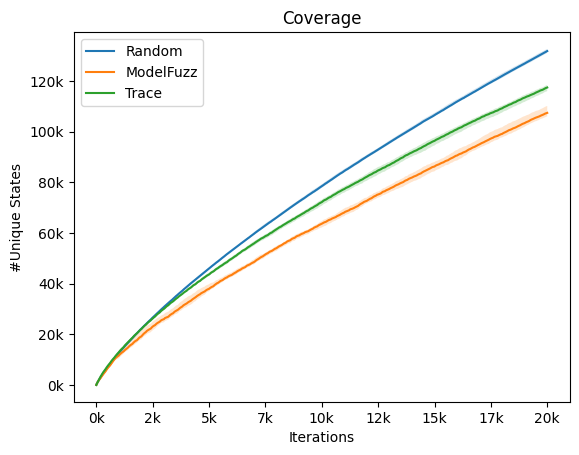

In [19]:
fig, ax = plt.subplots()

colors = {
    "Random": "tab:blue",
    "ModelFuzz": "tab:orange",
    "Trace": "tab:green",
}

for (b, bands) in coverages_plot.items():
    ax.plot(np.arange(len(bands[0])), bands[2], label=b, color=colors[b])
    ax.fill_between(np.arange(len(bands[0])), bands[0], bands[1], alpha=0.2)

ax.set_xlabel('Iterations')
ax.set_ylabel('#Unique States')
ax.set_title("Coverage")
ax.legend()

# ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([str(int(x/1000))+"k" for x in ax.get_xticks()])
# ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([str(int(y/1000))+"k" for y in ax.get_yticks()])

# plt.show()
plt.show()

In [16]:
all_bugs = {}
unexpected_bugs = {}
#r'\b\d+\b'
slice_ = 4000
for run in runs:
    for method in methods:
        bugs = []
        if method not in all_bugs.keys():
            all_bugs[method] = []
        if method not in unexpected_bugs.keys():
            unexpected_bugs[method] = []
        # print(f'{method} run: {run}')
        basedir = f'experiments/raft_3_3/{method}/output{run}/errors/'
        for file in os.listdir(basedir):
            iter = [int(n) for n in re.findall(r'\d+', file)][0]
            with open(f'{basedir}{file}/stderr.log', 'r') as f:
                lines = f.readlines()
            if 'Large LogIndex:' in lines[0]:
                li = [int(n) for n in re.findall(r'\b\d+\b', lines[0])]
                if li[0] < 4:
                    continue
                all_bugs[method].append((run, iter, li[0]))
            elif 'Negative LogIndex!' in lines[0]:
                print(f'Negative LogIndex at {(method, run, iter)}')
                all_bugs[method].append((run, iter, -1))
            else:
                unexpected_bugs[method].append((method, run, iter))
print(all_bugs)
print(unexpected_bugs)



Negative LogIndex at ('state', 13, 8015)
{'random': [(12, 5634, 4), (12, 64, 5), (12, 15689, 4), (12, 12243, 4), (12, 5959, 4), (12, 2052, 4), (13, 1712, 4), (13, 22208, 4), (13, 3854, 5), (13, 12433, 4), (13, 2890, 4), (13, 2837, 4), (13, 23476, 4), (13, 22308, 4), (13, 8063, 4), (13, 22205, 4), (13, 1248, 4), (13, 6204, 4), (14, 1573, 4), (14, 13540, 4), (14, 24414, 4), (14, 24470, 4), (14, 13828, 4), (14, 14854, 4), (14, 21512, 4), (14, 9574, 4), (14, 24108, 5), (14, 6860, 4), (14, 17268, 4), (14, 11100, 4)], 'state': [(12, 26328, 4), (12, 4628, 4), (12, 5874, 4), (12, 11780, 4), (13, 13639, 4), (13, 22344, 4), (13, 3366, 4), (13, 12960, 4), (13, 2994, 4), (13, 7667, 4), (13, 8015, -1), (13, 25920, 5), (13, 16707, 4), (14, 2980, 4), (14, 21399, 4), (14, 16178, 4), (14, 3882, 5), (14, 22305, 4), (14, 1106, 4), (14, 11766, 4), (14, 19643, 4), (14, 25480, 4), (14, 806, 4)], 'trace': [(12, 5505, 4), (12, 19521, 4), (12, 7871, 4), (12, 852, 4), (12, 8520, 4), (13, 22400, 4), (13, 274, 4)